In [138]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
import itertools
import termcolor
from termcolor import colored

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import pylab

from collections import defaultdict
from IPython.display import Image

In [2]:
def read_file(filename):
        string = open(filename, "r").read()
        string_list = string.split("\n")
        string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
        return string_list

In [3]:
results_folder = '../output/'
other_tools = '../../../results/eval/'
greedy_contig_chains = '../../../results/output/hyasp/'

In [4]:
#Overall stats; key:sample_id, values: precision, recall, f1, total_length
MILP_STATS = {}
HYASP_STATS= {}
PLASMIDSPADES_STATS = {}
MOBSUITE_STATS = {}
GPLAS_STATS = {}

#Precision by sample; key:sample_id, values: precision_ratio, precision_by_length, total_length
MILP_PREC = {}
HYASP_PREC= {}
PLASMIDSPADES_PREC = {}
MOBSUITE_PREC = {}
GPLAS_PREC = {}

#Precision by plasmid; key: sample_id_plasmid_id, values: precision_ratio, precision_by_length, order of output, gene density, length
MILP_PREC_PLASMID = {}
HYASP_PREC_PLASMID= {}
PLASMIDSPADES_PREC_PLASMID = {}
MOBSUITE_PREC_PLASMID= {}
GPLAS_PREC_PLASMID = {}

#Recall by sample; key:sample_id, values: recall_ratio, recall_by_length
MILP_REC = {}
HYASP_REC= {}
PLASMIDSPADES_REC = {}
MOBSUITE_REC = {}
GPLAS_REC = {}

#True plasmid length; key: plasmid_id, values: length
TP_LENGTH = {}

In [5]:
def read_eval_file(str_list, sample_id, tool):
    #print(str_list)
    #print(tool)
    #print(sample_id)
    stats = {}
    prec = {}
    prec_individual = {}
    rec = {}
    tp_length = {}

    d1 = 'number'
    d2 = '>'
    delim_count = 0
    
    #Overall stats
    precision, recall, f1, total_len, pred_len = 0, 0, 0, 0, 0 
    
    for line in str_list:
        #print(line)
        if d1 in line or d2 in line:
            delim_count += 1   
        #True plasmids & their lengths    
        if delim_count == 2:
            if 'nt' in line:
                line = line[1:].split(" ")
                plas = line[0][:-1]
                length = int(line[1])
                tp_length[plas] = length
        #Predicted plasmids & their lengths       
        elif delim_count == 3: 
            if 'nt' in line:
                line = line[1:].split(" ")
                plas = line[0][:-1]
                length = int(line[1])
                #output_order = int(plas.split('_')[1])
                prec_individual['sample_'+sample_id+'_'+plas] = {}
                prec_individual['sample_'+sample_id+'_'+plas]['Length'] = length
                #prec_individual['sample_'+sample_id+'_'+plas]['Order'] = output_order
                prec_individual['sample_'+sample_id+'_'+plas]['Sample'] = sample_id
                
        #Precision per plasmid        
        elif delim_count == 6:
            if '_' in line:    
                line = line.split("\t")
                plas = line[0]
                length = prec_individual['sample_'+sample_id+'_'+plas]['Length']
                prec_individual['sample_'+sample_id+'_'+plas]['Precision_length'] = length*float(line[1])
                prec_individual['sample_'+sample_id+'_'+plas]['Precision'] = float(line[1])
        #Recall per true plasmid
        #elif delim_count == 7:
        #    if '.' in line:    
        #        line = line.split("\t")
        #        p = line[0]
        #        length = tp_length[p]
        #        rec[p] = {}
        #        rec[p]['Recall'] = float(line[1])
        #        rec[p]['Recall_length'] = length*float(line[1])
        
        if "precision" in line:
            precision = float(line.split(" ")[-1])
        stats['Precision'] = precision
        prec['Precision'] = precision
        if "recall" in line:    
            recall = float(line.split(" ")[-1])
        stats['Recall'] = recall
        rec['Recall'] = recall
        if "f1_score" in line:
            f1 = float(line.split(" ")[-1])
        stats['F1'] = f1
           
    for p in tp_length:
        total_len += tp_length[p]
    stats['Length'] = total_len
    rec['Length'] = total_len
    rec['Recall_length'] = rec['Recall']*total_len  
        
    for p in prec_individual:
        pred_len += prec_individual[p]['Length']
    prec['Precision_length'] = prec['Precision']*pred_len   
    prec['Length'] = pred_len
        
    #print(prec_individual)    
            
    return stats, prec, rec, prec_individual, tp_length   

In [6]:
#def get_true_plasmid_details(str_list, plasmids_dict):
def get_plasmid_gd(str_list, plasmids, sample_id):
    for line in str_list:
        if line[0] == '>':
            line = line.split("\t")
            #print(line)
            p = 'sample_'+sample_id+'_'+line[0][1:]
            #print(p)
            for i in range(len(line)):
                if 'gene_density' in line[i]:
                    gd = float(line[i].split('=')[1])
            plasmids[p]['Gene_density'] = gd
    return plasmids  

In [7]:
ids = [15,16,18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52]
for i in ids:
    #print(i)
    sample_id = str(i)
    
    mobsuite_eval_file = other_tools+'sample_'+sample_id+'/mob_recon_eval.csv'
    str_list = read_file(mobsuite_eval_file)
    MOBSUITE_STATS[sample_id], MOBSUITE_PREC[sample_id], MOBSUITE_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'MOBSUITE')
    MOBSUITE_PREC_PLASMID.update(prec_sample)    
    
    plasmidspades_eval_file = other_tools+'sample_'+sample_id+'/plasmidspades_eval.csv'
    str_list = read_file(plasmidspades_eval_file)
    PLASMIDSPADES_STATS[sample_id], PLASMIDSPADES_PREC[sample_id], PLASMIDSPADES_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'PLASMIDSPADES')
    PLASMIDSPADES_PREC_PLASMID.update(prec_sample)

        
    
    MILP_eval_file = results_folder+'sample_'+sample_id+'/1.1.1/nplasmids_1/eval/MILP/MILP_eval.csv'
    str_list = read_file(MILP_eval_file)
    prec_sample = {}
    tplen_sample = {}

    MILP_STATS[sample_id], MILP_PREC[sample_id], MILP_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'MILP')
    MILP_PREC_PLASMID.update(prec_sample)
    TP_LENGTH.update(tplen_sample)
    
    #greedy_eval_file = results_folder+'sample_'+sample_id+'/1.1.1/nplasmids_1/eval/MILP/greedy_eval.csv'
    greedy_eval_file = other_tools+'sample_'+sample_id+'/greedy_eval.csv'
    str_list = read_file(greedy_eval_file)
    HYASP_STATS[sample_id], HYASP_PREC[sample_id], HYASP_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'GPLAS')
    HYASP_PREC_PLASMID.update(prec_sample)
    
    gplas_eval_file = other_tools+'sample_'+sample_id+'/gplas_eval.csv'
    str_list = read_file(gplas_eval_file)
    GPLAS_STATS[sample_id], GPLAS_PREC[sample_id], GPLAS_REC[sample_id], prec_sample, tplen_sample = read_eval_file(str_list,sample_id,'GPLAS')
    GPLAS_PREC_PLASMID.update(prec_sample)    
    
    MILP_gd_file = results_folder+'sample_'+sample_id+'/1.1.1/nplasmids_1/MILP/MILP_putative_plasmids.fasta'
    str_list = read_file(MILP_gd_file)
    
    MILP_PREC_PLASMID = get_plasmid_gd(str_list, MILP_PREC_PLASMID, sample_id)
#print(MILP_PREC_PLASMID)    

In [13]:
MILP_DF = pd.DataFrame.from_dict(MILP_STATS).T
HYASP_DF = pd.DataFrame.from_dict(HYASP_STATS).T
PLASMIDSPADES_DF = pd.DataFrame.from_dict(PLASMIDSPADES_STATS).T
MOBSUITE_DF = pd.DataFrame.from_dict(MOBSUITE_STATS).T
GPLAS_DF = pd.DataFrame.from_dict(GPLAS_STATS).T

HYASP_DF = HYASP_DF.drop(columns=['Length'])
PLASMIDSPADES_DF = PLASMIDSPADES_DF.drop(columns=['Length'])
MOBSUITE_DF = MOBSUITE_DF.drop(columns=['Length'])
GPLAS_DF = GPLAS_DF.drop(columns=['Length'])

HYASP_DF = HYASP_DF.rename(columns={"Precision": "greedy_Precision", "Recall": "greedy_Recall", "F1": "greedy_F1"})
PLASMIDSPADES_DF = PLASMIDSPADES_DF.rename(columns={"Precision": "plasmidspades_Precision", "Recall": "plasmidspades_Recall", "F1": "plasmidspades_F1"})
MOBSUITE_DF = MOBSUITE_DF.rename(columns={"Precision": "mobsuite_Precision", "Recall": "mobsuite_Recall", "F1": "mobsuite_F1"})
GPLAS_DF = GPLAS_DF.rename(columns={"Precision": "gplas_Precision", "Recall": "gplas_Recall", "F1": "gplas_F1"})

ALL_DF = MILP_DF.join(HYASP_DF)
ALL_DF = ALL_DF.join(PLASMIDSPADES_DF)
ALL_DF = ALL_DF.join(MOBSUITE_DF)
ALL_DF = ALL_DF.join(GPLAS_DF)

## Distribution of plasmid lengths

### By sample: cumulative length of all plasmids in the sample

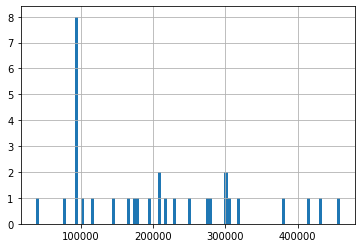

In [9]:
hist = ALL_DF['Length'].hist(bins=100)

### By plasmid: individual length of plasmids

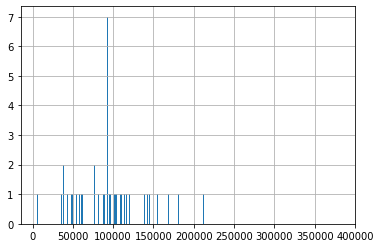

In [10]:
TPLEN_DF = pd.DataFrame(TP_LENGTH, index=['Length']).T
hist = TPLEN_DF['Length'].hist(bins=500)

## Precision, Recall and F1

In [11]:
ALL_DF['Category'] = ALL_DF['Length']//100000

In [12]:
ALL_DF

,Precision,Recall,F1,Length,gplas_Precision,gplas_Recall,gplas_F1,Category
15,0.790326,0.873603,0.829881,430944.0,0.939058,0.644789,0.764587,4.0
16,0.936455,0.901358,0.918572,279233.0,0.889965,0.749392,0.813652,2.0
18,0.932611,0.680263,0.786696,303199.0,0.931778,0.525981,0.672399,3.0
19,0.916418,0.996709,0.954879,208131.0,1.000000,0.374807,0.545251,2.0
23,0.018301,0.040496,0.025209,37362.0,0.218030,0.810021,0.343580,0.0
24,0.986134,0.999416,0.992730,458871.0,1.000000,0.650730,0.788415,4.0
25,0.881414,1.000000,0.936970,177752.0,1.000000,0.526554,0.689860,1.0
26,0.820515,1.000000,0.901410,116529.0,1.000000,0.881437,0.936983,1.0
27,0.904695,1.000000,0.949963,300203.0,1.000000,0.370293,0.540458,3.0
28,0.731931,0.999995,0.845218,215053.0,1.000000,0.976471,0.988095,2.0


In [14]:
print("MILP\t\tHyAsP\t\tPlasmidSPAdes\tMOB-suite\tgplas")
print(ALL_DF['Precision'].mean(),"\t",ALL_DF['greedy_Precision'].mean(),"\t",ALL_DF['plasmidspades_Precision'].mean(),"\t",ALL_DF['mobsuite_Precision'].mean(),"\t",ALL_DF['gplas_Precision'].mean())
print(ALL_DF['Recall'].mean(),"\t",ALL_DF['greedy_Recall'].mean(),"\t",ALL_DF['plasmidspades_Recall'].mean(),"\t",ALL_DF['mobsuite_Recall'].mean(),"\t",ALL_DF['gplas_Recall'].mean())
print(ALL_DF['F1'].mean(),"\t",ALL_DF['greedy_F1'].mean(),"\t",ALL_DF['plasmidspades_F1'].mean(),"\t",ALL_DF['mobsuite_F1'].mean(),"\t",ALL_DF['gplas_F1'].mean())


MILP		HyAsP		PlasmidSPAdes	MOB-suite	gplas
0.76689909375 	 0.7856519375 	 0.62163528125 	 0.8048830625 	 0.92724984375
0.80573778125 	 0.80945184375 	 0.7842270312499999 	 0.48168359374999997 	 0.6816557187500001
0.77343540625 	 0.7735112187500001 	 0.6321629375 	 0.5534623437499999 	 0.7639


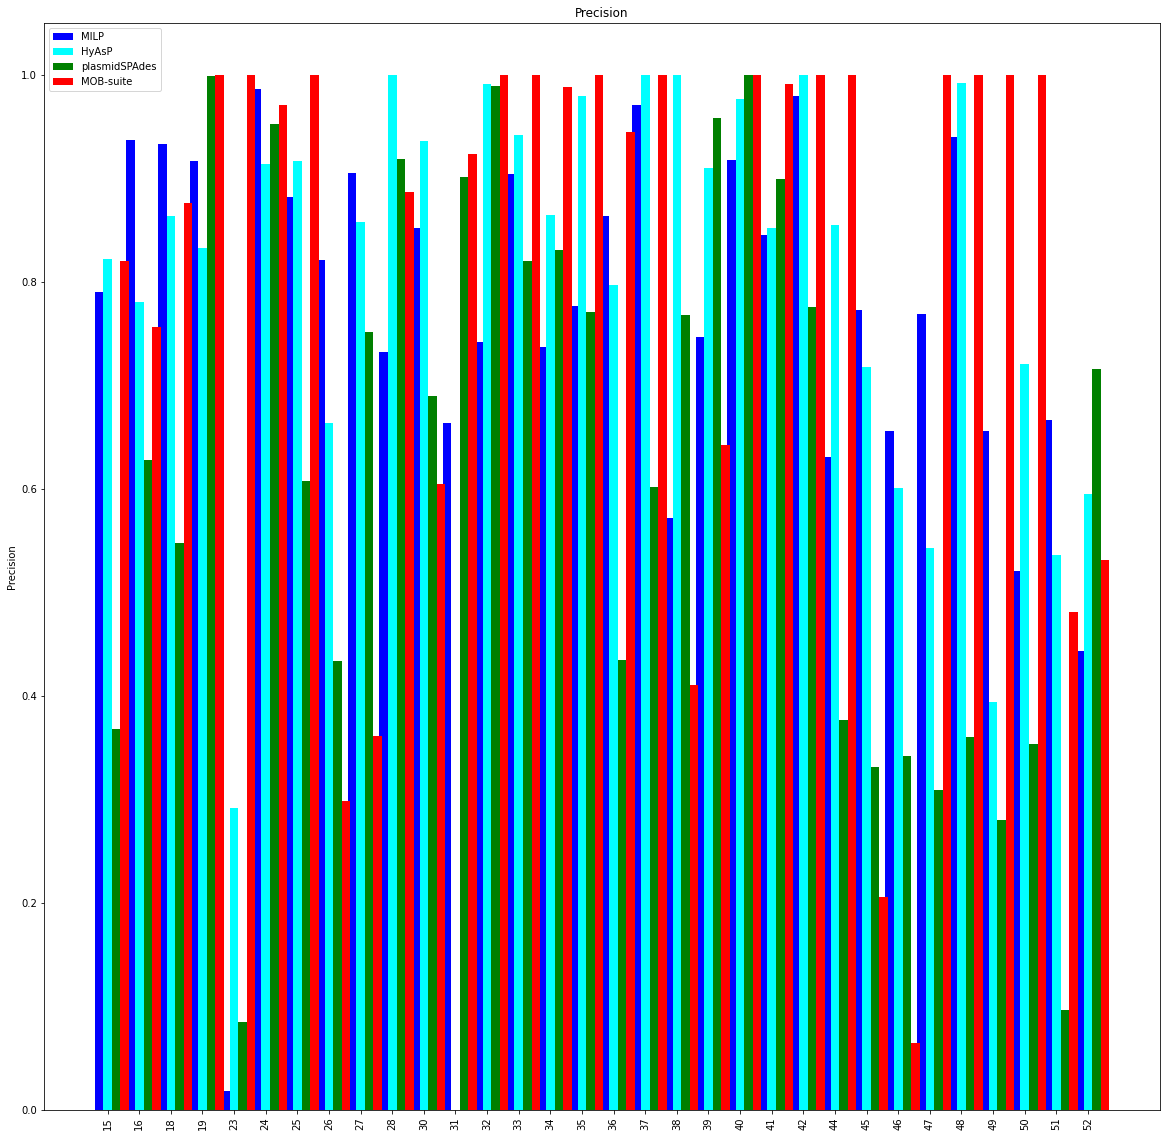

In [14]:
N = len(ids)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(ids)
#ids = [k.split('_')[1] for k in ids]

pvals = ALL_DF['Precision'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='blue')
gpvals = ALL_DF['greedy_Precision'].values.tolist()
rects2 = axp.bar(ind+width, gpvals, width, color='cyan')
ppvals = ALL_DF['plasmidspades_Precision'].values.tolist()
rects3 = axp.bar(ind+2*width, ppvals, width, color='green')
mpvals = ALL_DF['mobsuite_Precision'].values.tolist()
rects4 = axp.bar(ind+3*width, mpvals, width, color='red')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Precision')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('MILP', 'HyAsP', 'plasmidSPAdes', 'MOB-suite') )
plt.xticks(rotation=90)
plt.title("Precision")
plt.show()

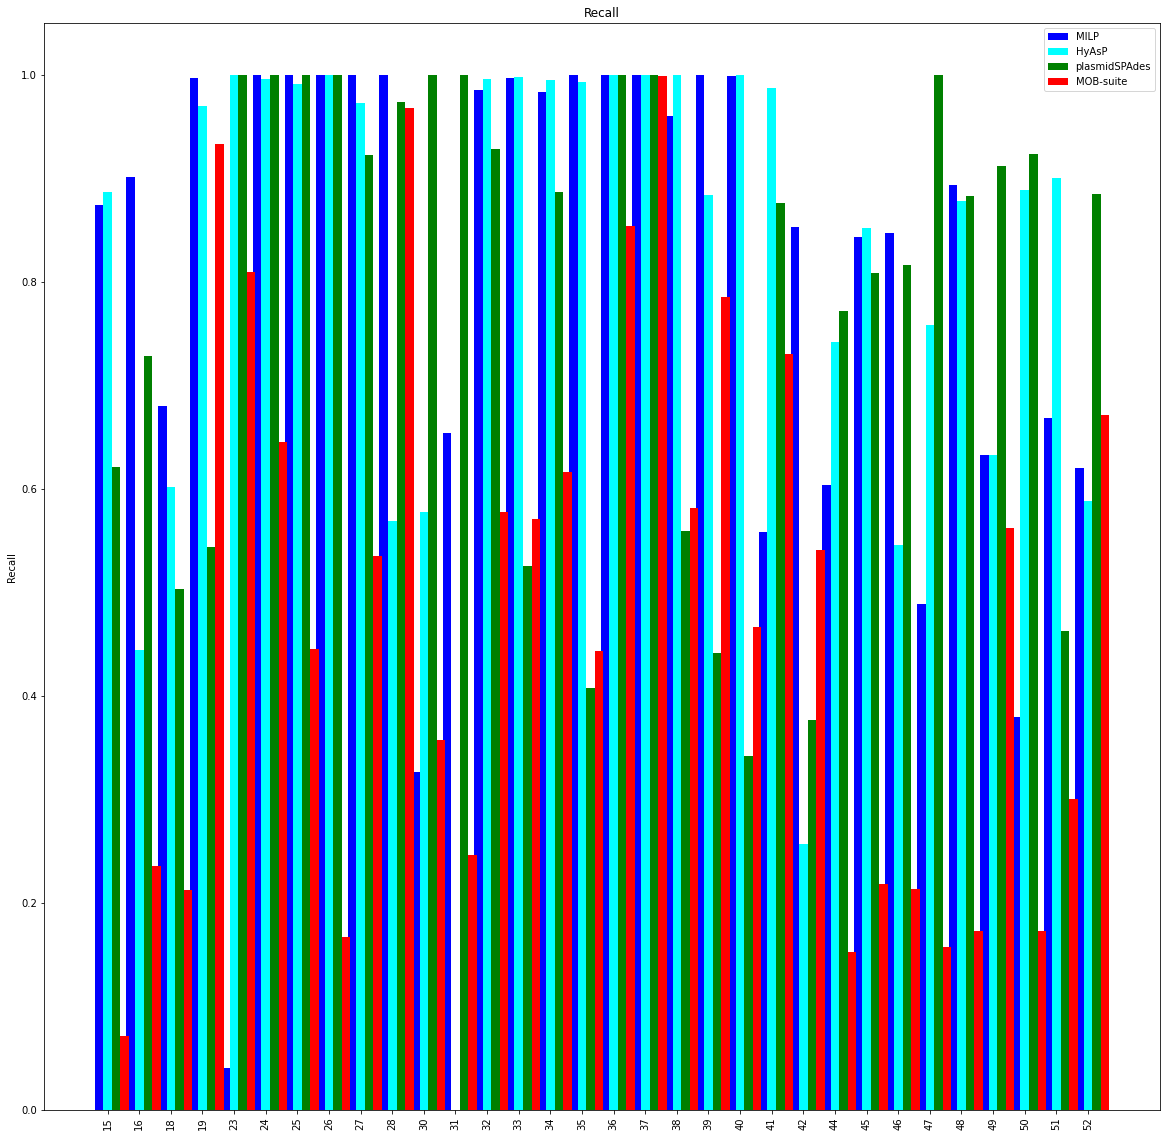

In [15]:
N = len(ids)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(ids)
#ids = [k.split('_')[1] for k in ids]

pvals = ALL_DF['Recall'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='blue')
gpvals = ALL_DF['greedy_Recall'].values.tolist()
rects2 = axp.bar(ind+width, gpvals, width, color='cyan')
ppvals = ALL_DF['plasmidspades_Recall'].values.tolist()
rects3 = axp.bar(ind+2*width, ppvals, width, color='green')
mpvals = ALL_DF['mobsuite_Recall'].values.tolist()
rects4 = axp.bar(ind+3*width, mpvals, width, color='red')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Recall')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('MILP', 'HyAsP', 'plasmidSPAdes', 'MOB-suite') )
plt.xticks(rotation=90)
plt.title("Recall")
plt.show()

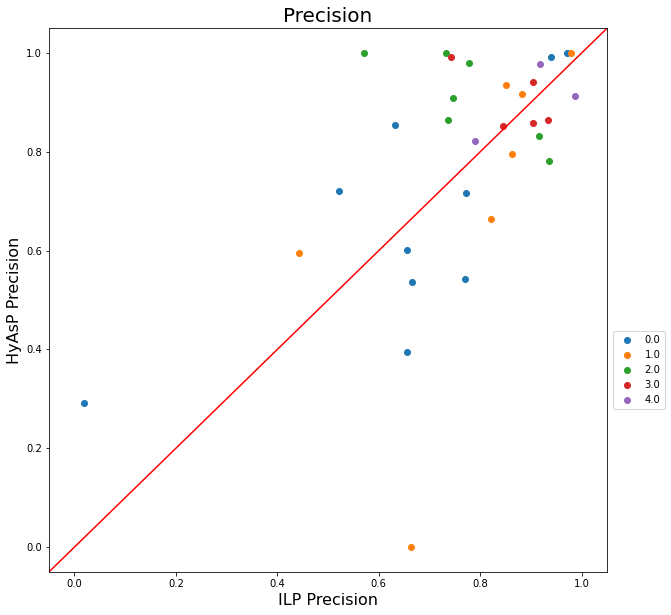

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
for name, group in groups:
    plt.scatter(group['Precision'], group['greedy_Precision'], label=name)
plt.axline([0, 0], [1, 1], color = 'r')    
plt.legend(loc=[1.01,0.3])
plt.title("Precision", fontsize=20)
plt.xlabel('ILP Precision', fontsize=16)
plt.ylabel('HyAsP Precision', fontsize=16)
plt.show()

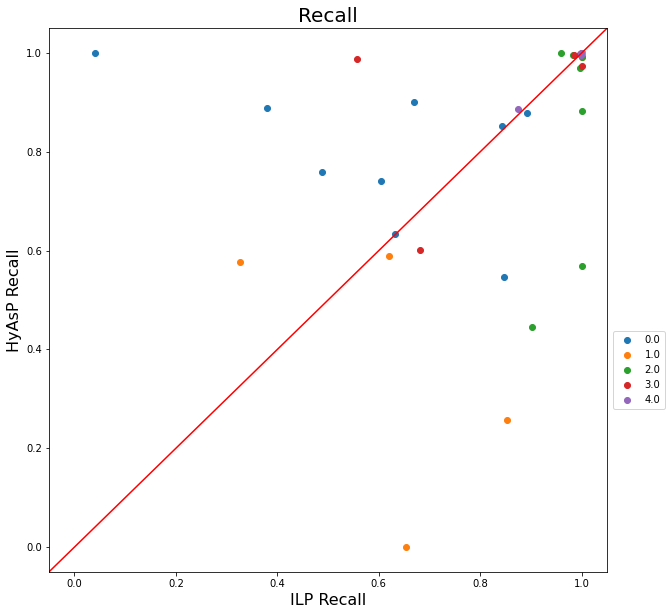

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
for name, group in groups:
    plt.scatter(group['Recall'], group['greedy_Recall'], label=name)
plt.axline([0, 0], [1, 1], color = 'r')    
plt.legend(loc=[1.01,0.3])
plt.title("Recall", fontsize=20)
plt.xlabel('ILP Recall', fontsize=16)
plt.ylabel('HyAsP Recall', fontsize=16)
plt.show()

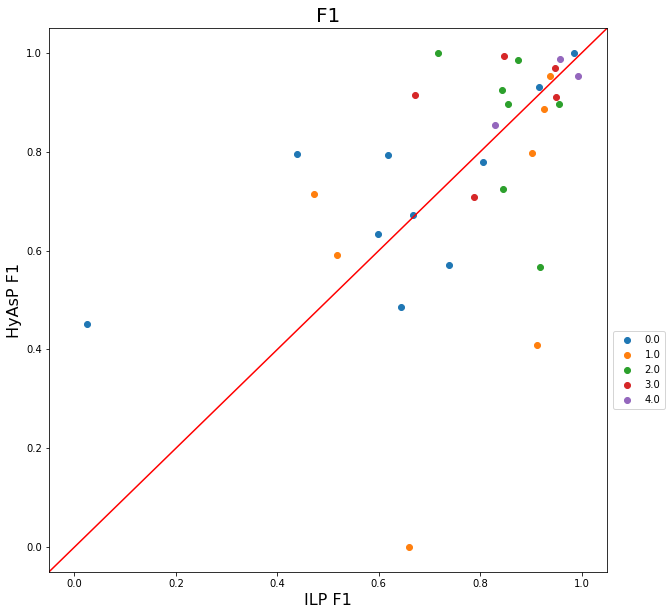

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ncolors = len(ALL_DF.keys())
samples = list(ALL_DF.keys())
groups = ALL_DF.groupby('Category')
for name, group in groups:
    plt.scatter(group['F1'], group['greedy_F1'], label=name)
plt.axline([0, 0], [1, 1], color = 'r')    
plt.legend(loc=[1.01,0.3])
plt.title("F1", fontsize=20)
plt.xlabel('ILP F1', fontsize=16)
plt.ylabel('HyAsP F1', fontsize=16)
plt.show()

## Correct vs incorrect predictions - by length

### By sample: Precision by cumulative length for all plasmids in the sample

In [19]:
MILP_PREC_DF = pd.DataFrame.from_dict(MILP_PREC).T
HYASP_PREC_DF= pd.DataFrame.from_dict(HYASP_PREC).T

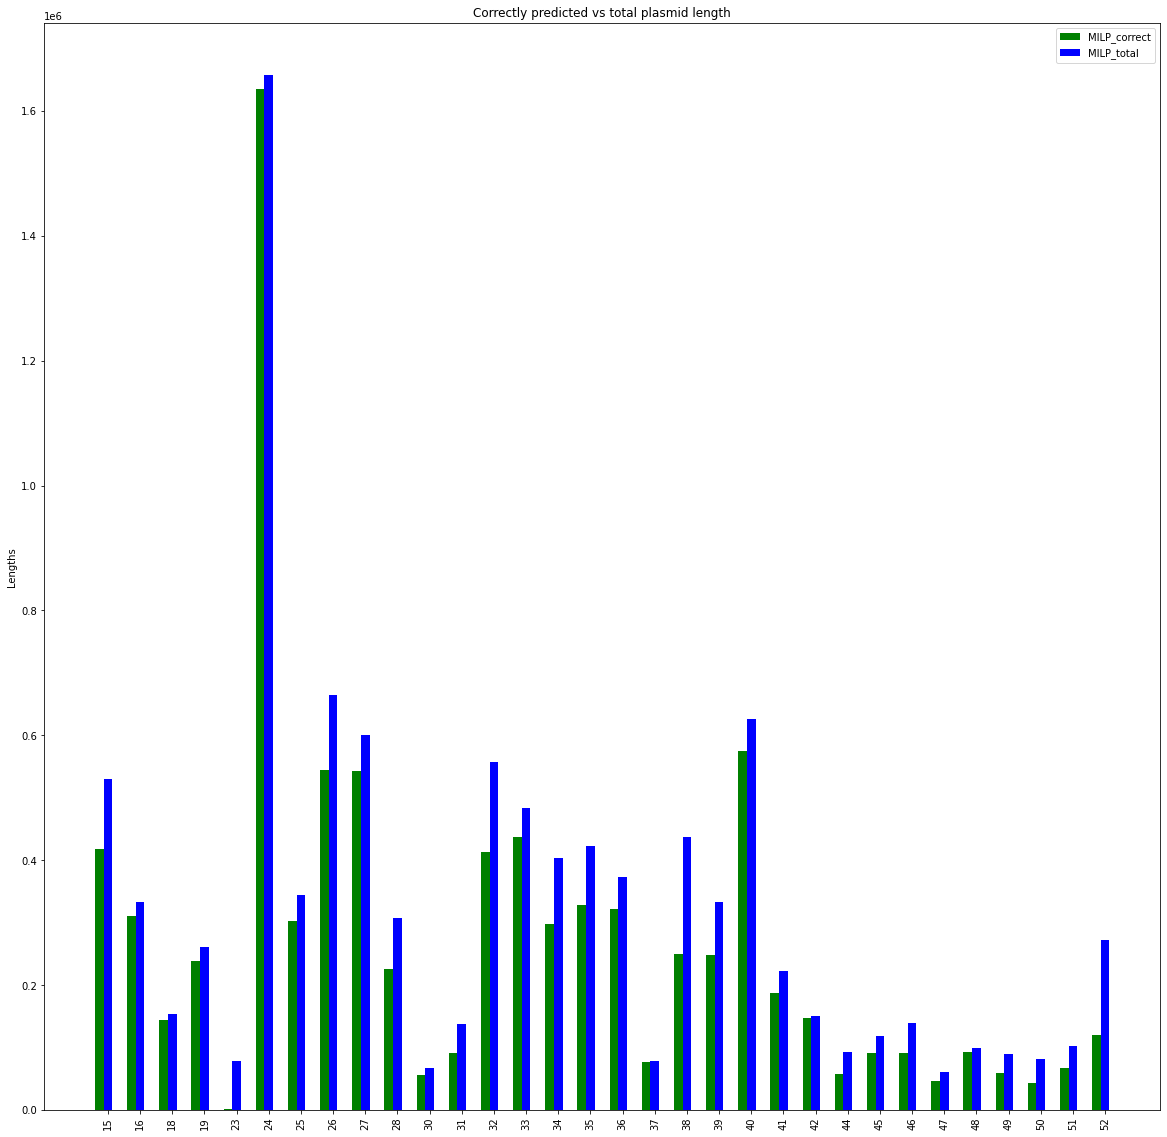

In [20]:
N = len(ids)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(MILP_PREC.keys())
#ids = [k.split('_')[1] for k in ids]

pvals = MILP_PREC_DF['Precision_length'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
tlvals = MILP_PREC_DF['Length'].values.tolist()
rects2 = axp.bar(ind+width, tlvals, width, color='b')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Lengths')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects2[0]), ('MILP_correct', 'MILP_total') )
plt.xticks(rotation=90)
plt.title("Correctly predicted vs total plasmid length")
plt.show()

### By sample: Recall by cumulative length for all true plasmids in the sample

In [21]:
MILP_REC_DF = pd.DataFrame.from_dict(MILP_REC).T
HYASP_REC_DF= pd.DataFrame.from_dict(HYASP_REC).T

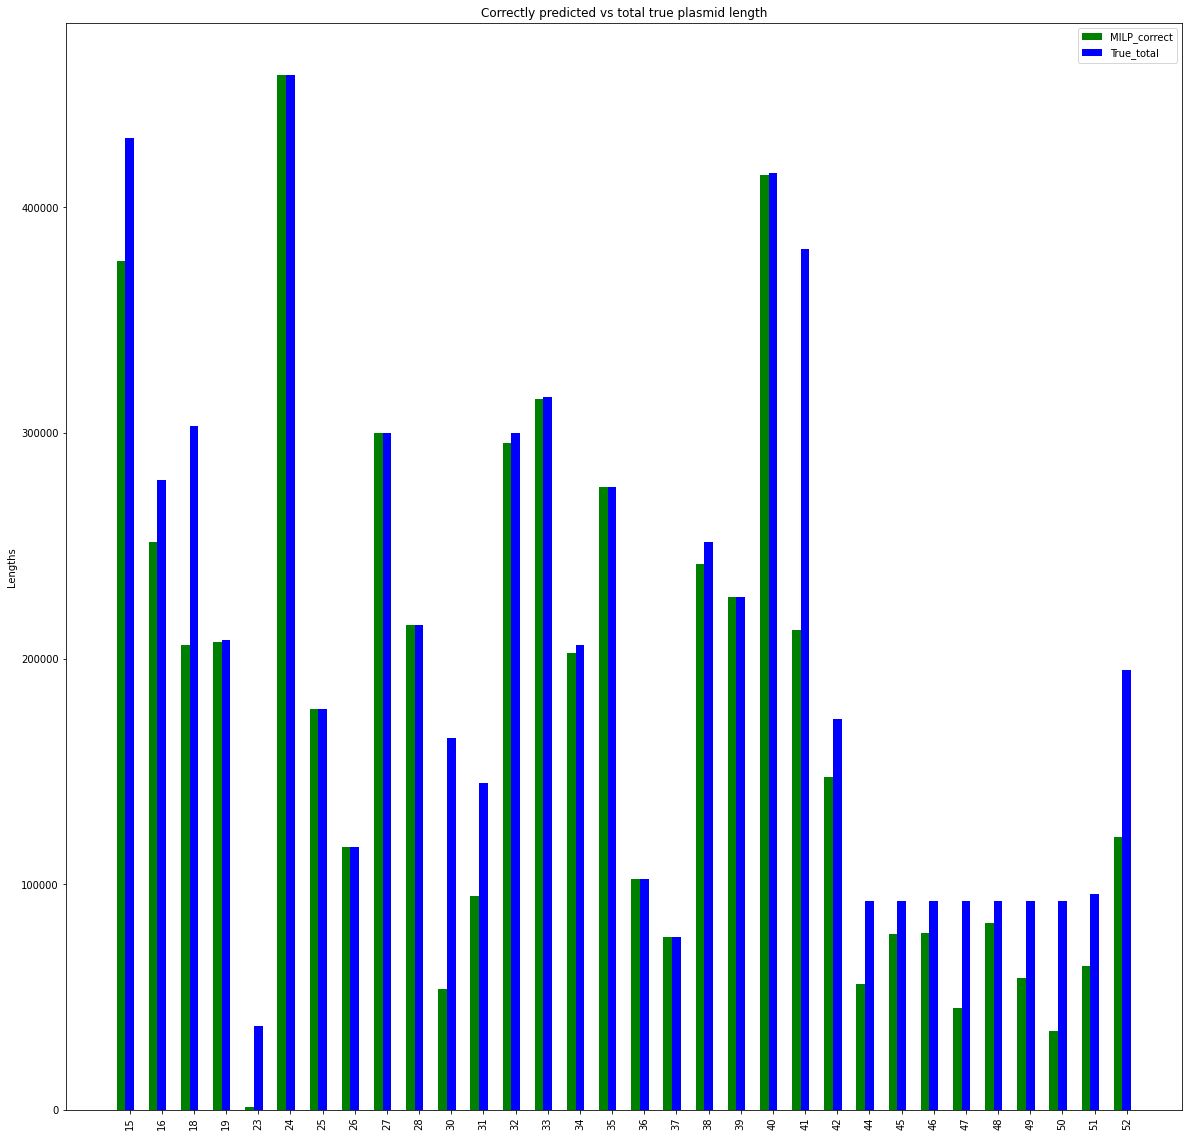

In [22]:
N = len(ids)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(20,20))

axp = fig.add_subplot(111)

#ids = list(MILP_REC.keys())
#ids = [k.split('_')[1] for k in ids]

pvals = MILP_REC_DF['Recall_length'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
tlvals = MILP_REC_DF['Length'].values.tolist()
rects2 = axp.bar(ind+width, tlvals, width, color='b')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Lengths')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects2[0]), ('MILP_correct', 'True_total') )
plt.xticks(rotation=90)
plt.title("Correctly predicted vs total true plasmid length")
plt.show()

### By plasmid: Precision by length for individual plasmid

In [23]:
MILP_PREC_PLASMID_DF = pd.DataFrame.from_dict(MILP_PREC_PLASMID).T
HYASP_PREC_PLASMID_DF= pd.DataFrame.from_dict(HYASP_PREC_PLASMID).T

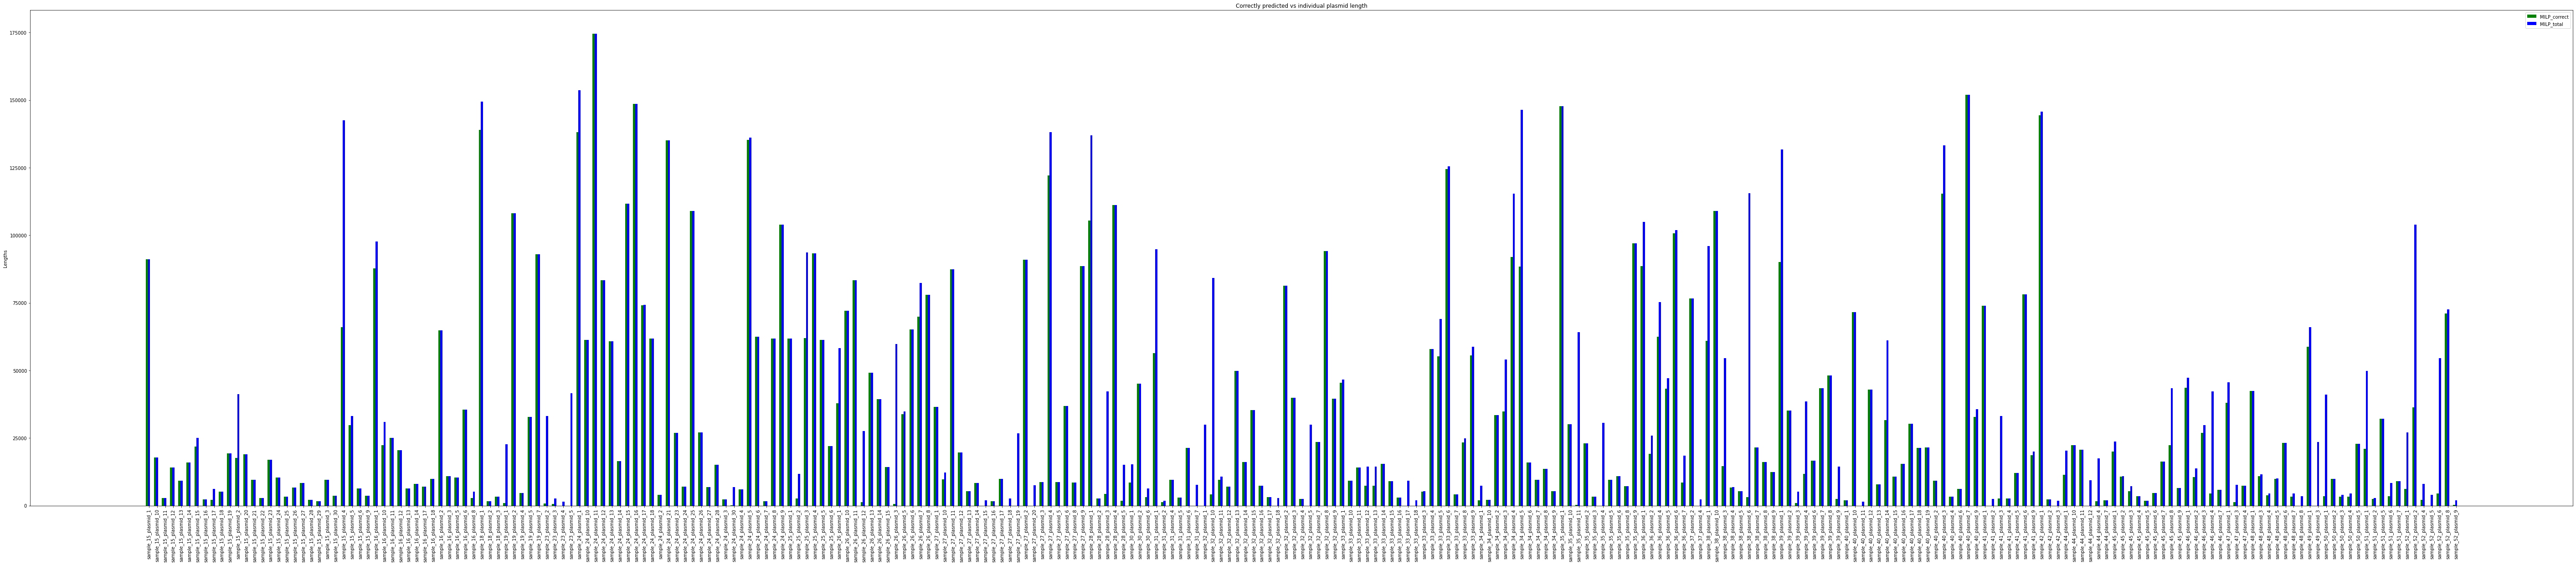

In [24]:
N = len(MILP_PREC_PLASMID)
ind = np.arange(N)
width = 0.27

fig = plt.figure(figsize=(100,20))

axp = fig.add_subplot(111)

ids = list(MILP_PREC_PLASMID.keys())
#ids = [k.split('_')[1] for k in ids]

pvals = MILP_PREC_PLASMID_DF['Precision_length'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
tlvals = MILP_PREC_PLASMID_DF['Length'].values.tolist()
rects2 = axp.bar(ind+width, tlvals, width, color='b')

#gpvals = HYASP_PREC_DF['Precision_length'].values.tolist()
#rects3 = axp.bar(ind+2*width, tlvals, width, color='r')
#gtlvals = HYASP_PREC_DF['Length'].values.tolist()
#rects4 = axp.bar(ind+3*width, gpvals, width, color='b')
axp.set_ylabel('Lengths')
axp.set_xticks(ind+width)
axp.set_xticklabels([(ids[i]) for i in range(len(ids))])
axp.legend( (rects1[0], rects2[0]), ('MILP_correct', 'MILP_total') )
plt.xticks(rotation=90)
plt.title("Correctly predicted vs individual plasmid length")
plt.show()

In [25]:
MILP_PREC_PLASMID_DF 

,Length,Sample,Precision_length,Precision,Gene_density
sample_15_plasmid_1,91082,15,91082.0,1.0,0.830603
sample_15_plasmid_10,17817,15,17817.0,1.0,0.823652
sample_15_plasmid_11,2749,15,2738.999138,0.996362,0.425609
sample_15_plasmid_12,14049,15,14038.997112,0.999288,0.761122
sample_15_plasmid_13,9164,15,9164.0,1.0,0.8433
...,...,...,...,...,...
sample_52_plasmid_4,8096,52,2132.996448,0.263463,0.402915
sample_52_plasmid_5,4072,52,0.0,0.0,0.593075
sample_52_plasmid_6,54514,52,4576.99544,0.08396,0.673497
sample_52_plasmid_8,72631,52,71118.967842,0.979182,0.792155


## Scatterplots for precision

### Precision vs predicted length

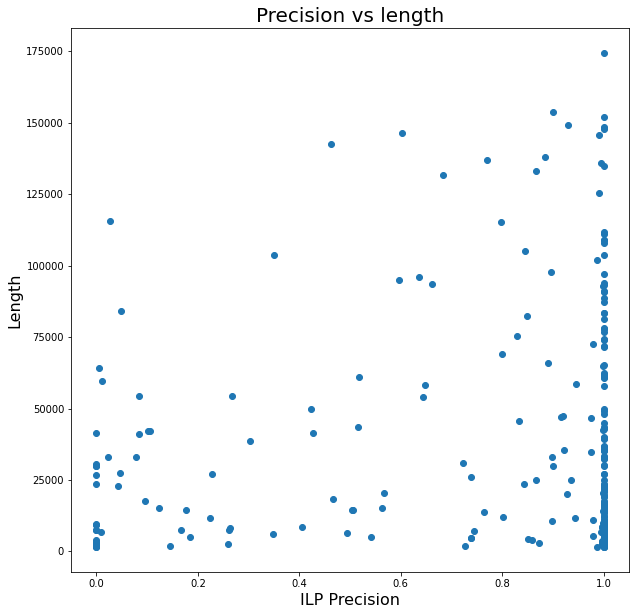

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
#ncolors = len(MILP_PREC.keys())
#samples = list(ALL_DF.keys())
#groups = MILP_PREC_PLASMID_DF.groupby('Sample')
#for name, group in groups:
plt.scatter(MILP_PREC_PLASMID_DF['Precision'], MILP_PREC_PLASMID_DF['Length'])

#plt.legend(loc=[1.01,0.3])
plt.title("Precision vs length", fontsize=20)
plt.xlabel('ILP Precision', fontsize=16)
plt.ylabel('Length', fontsize=16)
plt.show()

### Precision vs order of output

In [27]:
#fig, ax = plt.subplots(figsize=(10,10))
#ncolors = len(ALL_DF.keys())
#samples = list(ALL_DF.keys())
#groups = ALL_DF.groupby('Category')
#for name, group in groups:
#plt.scatter(MILP_PREC_PLASMID_DF['Order'], MILP_PREC_PLASMID_DF['Precision'])

#plt.legend(loc=[1.01,0.3])
#plt.title("Order of output vs Precision", fontsize=20)
#plt.xlabel('Order of output', fontsize=16)
#plt.ylabel('ILP Precision', fontsize=16)
#plt.show()

### Precision vs gene density

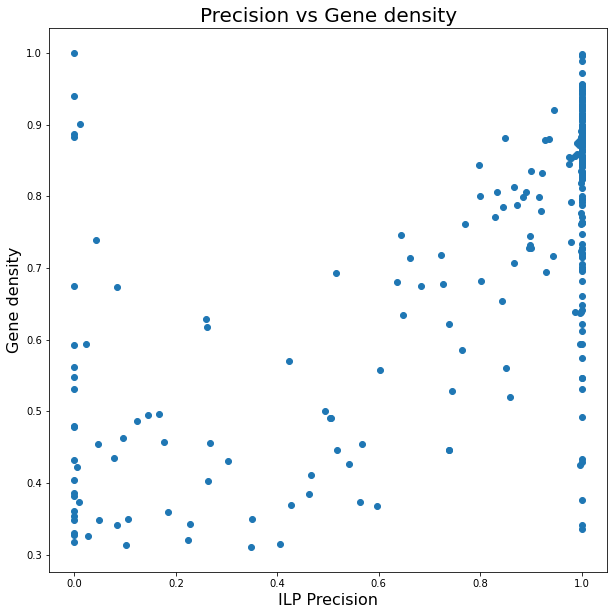

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
#ncolors = len(ALL_DF.keys())
#samples = list(ALL_DF.keys())
#groups = ALL_DF.groupby('Category')
#for name, group in groups:
plt.scatter(MILP_PREC_PLASMID_DF['Precision'], MILP_PREC_PLASMID_DF['Gene_density'])

#plt.legend(loc=[1.01,0.3])
plt.title("Precision vs Gene density", fontsize=20)
plt.xlabel('ILP Precision', fontsize=16)
plt.ylabel('Gene density', fontsize=16)
plt.show()